#### Intro

In this notebook I stitched together some code I found of someone attempting to DeepDream spectrograms with the original
Google DeepDream model (InceptionV3), to hear the results.

The results are unspectacular, as all it seems to do is make the signal noisy. Next step is to apply this concept
with an audio specific classifier.

*reference to code used below.*

In [2]:
from typing import List

import IPython.display as display
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import Tensor

import utils.constants as consts
from deep_dream import DeepDreamer
from utils.audio_tools import create_audio_player

PATH_TO_AUDIO: str = '../media/audio'

##### Load audio

In [3]:
sample: np.ndarray = librosa.load(f'{PATH_TO_AUDIO}/violin.wav', mono=True)[0]
create_audio_player(sample)

#### Convert audio into an image that can be processed by DeepDreamer object.

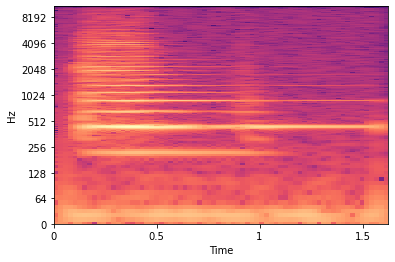

In [6]:
# This block of code is not my code.
# Source: https://github.com/markostam/audio-deepdream-tf/blob/master/deep_audio_dreams.ipynb

hop = 256
y_stft = librosa.core.stft(sample, n_fft=consts.NUM_FFT, hop_length=hop, center=True)

# Separate the magnitude and phase
y_stft_mag1, y_stft_ang = librosa.magphase(y_stft)

# Scale the spectrogram such that its values correspond to 0-255 (16-bit rgb amplitude)
nonlin = 1.0 / 8.0

y_stft_mag = np.power(y_stft_mag1, nonlin)
y_stft_mag = np.flipud((1 - y_stft_mag / y_stft_mag.max()))
y_stft_mag_rgb = np.zeros([y_stft_mag.shape[0], y_stft_mag.shape[1], 3])
y_stft_mag_rgb[:, :, 0] = y_stft_mag
y_stft_mag_rgb[:, :, 1] = y_stft_mag
y_stft_mag_rgb[:, :, 2] = y_stft_mag

img = 255 * y_stft_mag_rgb

# Show original audio log magnitude spectrogram
librosa.display.specshow(data=np.log(np.abs(y_stft_mag1)), sr=consts.SAMPLE_RATE, x_axis='time', y_axis='log')
base_shape: Tensor = tf.shape(img)[:-1]  # Original size of image shape, used to resize final deepdream.

plt.show()

##### DreamDream image

In [7]:
# Maximize the activations of these layers.
layer_names: List[str] = [
    'mixed2',
    'mixed1'
]

deep_dreamer = DeepDreamer(layer_names)

# Change settings below to achieve different results.
dreamified_image: Tensor = deep_dreamer.dreamify(
    _img=img,
    steps_per_octave=25,
    step_size=0.02,
    octaves=range(-2, 5),
    octave_scale=1.3,
)

# Clear anything that might have been draw such as warnings.
display.clear_output(wait=True)

dreamified_image = tf.image.resize(dreamified_image, base_shape)  # Resize image to original image size.
dreamified_image = tf.image.convert_image_dtype(dreamified_image / 255.0, dtype=tf.uint8)

(1025, 70)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'layer_activations' can't be nonlocal (__autograph_generated_file627xjvg9.py, line 23)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'layer_activations' can't be nonlocal (__autograph_generated_file627xjvg9.py, line 23)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-03-28 19:23:17.141419: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 28271232 exceeds 10% of free system memory.
2022-03-28 19:23:17.150165: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 28271232 exceeds 10% of free system memory.
2022-03-28 19:23:17.229882: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 28271232 exceeds 10% of free system memory.
2022-03-28 19:23:17.235613: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 28271232 exceeds 10% of free system memory.
2022-03-28 19:23:17.319238: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 28271232 exceeds 10% of free system memory.


#### Convert dreamified image back into an audio signal.

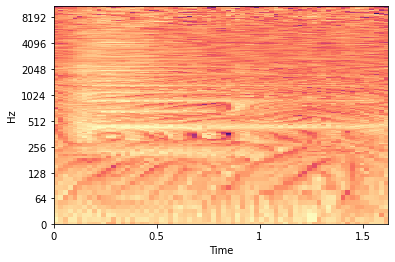

In [8]:
# This block of code is not my code.
# Source: https://github.com/markostam/audio-deepdream-tf/blob/master/deep_audio_dreams.ipynb

# Undo processing to bring the image back from 0-255 to original scale.
deepdream_out = np.flipud(dreamified_image)
deepdream_out = (1 - deepdream_out) * y_stft_mag.max()
deepdream_out = np.power(deepdream_out, 1 / nonlin)

# Flatten the three channels and normalize over number of channels.
deepdream_out = np.sum(deepdream_out, axis=2) / 3.0

# Show the new log-spectrogram.
librosa.display.specshow(np.log(np.abs(deepdream_out)), sr=consts.SAMPLE_RATE, x_axis='time', y_axis='log')
plt.show()

# add back in the original phase
deepdream_out_orig = deepdream_out.copy()
deepdream_out = deepdream_out * y_stft_ang

In [9]:
# add back in original phase
orig_stft_ang = librosa.magphase(y_stft)[1]
deepdream_out_with_phase = deepdream_out_orig * orig_stft_ang

In [1]:
# play with fixed phase
output = librosa.core.istft(deepdream_out_with_phase, hop_length=hop, win_length=2048, center=True)
create_audio_player(output, normalize=True)  # Result appears to be a noisy signal.

NameError: name 'librosa' is not defined